In [1]:
%%capture
!pip install tensorflow scikit-learn pandas numpy tqdm keras-preprocessing 


In [2]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.applications import MobileNetV2, ResNet152, ResNet50, VGG16, EfficientNetB0, InceptionV3
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input, Activation
from keras.optimizers import Adam
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def createdataframe(dirs):
    image_paths = []
    labels = []
    
    # Process each directory
    for dir in dirs:
        for label in os.listdir(dir):
            # Loop through images in subdirectories
            for imagename in os.listdir(os.path.join(dir, label)):
                image_path = os.path.join(dir, label, imagename)
                
                # Check if the image is not in the removed list
                if image_path not in REMOVED_IMAGES:
                    image_paths.append(image_path)
                    labels.append(label)
            print(label, "completed in", dir)
    
    return image_paths, labels

In [4]:
def extract_features(image_paths):
    features = []
    for image_path in tqdm(image_paths):
        try:
            img = load_img(image_path, target_size=(224,224))  # Load image
            img = np.array(img)  # Convert to numpy array
            features.append(img)  # Append to features
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    
    features = np.array(features).reshape(-1, 224, 224, 3)  # Reshape all valid images
    print(f"Successfully extracted features for {len(features)} images.")
    return features


In [5]:
def generate_unique_names(image_paths, labels):
    unique_names = []
    
    # Create unique names for images
    for idx, (path, label) in enumerate(zip(image_paths, labels)):
        extension = os.path.splitext(path)[1]  # Get file extension
        unique_name = f"{label}_image_{idx}{extension}"  # Create unique name
        unique_names.append(unique_name)
    
    return unique_names

In [6]:
# Count images in the dataset
new_ai_images = len(os.listdir('/kaggle/input/all-train-images/New_Data/AI'))
new_real_images = len(os.listdir('/kaggle/input/all-train-images/New_Data/Real'))

print(f"New AI images: {new_ai_images}")
print(f"New Real images: {new_real_images}")


New AI images: 296
New Real images: 296


In [7]:
old_ai_images = len(os.listdir('/kaggle/input/totaldata/Data/Train/AI'))
old_real_images = len(os.listdir('/kaggle/input/totaldata/Data/Train/Real'))

print(f"Old AI images: {old_ai_images}")
print(f"Old Real images: {old_real_images}")

Old AI images: 401
Old Real images: 400


In [8]:
TRAIN_DIR1 = "/kaggle/input/all-train-images/New_Data"
TRAIN_DIR2 = "/kaggle/input/totaldata/Data/Train"
REMOVED_IMAGES = [
    "/kaggle/input/all-train-images/New_Data/AI/image_530.jpg",
    "/kaggle/input/all-train-images/New_Data/AI/image_326.jpg"
]

# Combine directories
dirs = [TRAIN_DIR1, TRAIN_DIR2]
image_paths, labels = createdataframe(dirs)

# Generate unique names for images
unique_names = generate_unique_names(image_paths, labels)

AI completed in /kaggle/input/all-train-images/New_Data
Real completed in /kaggle/input/all-train-images/New_Data
AI completed in /kaggle/input/totaldata/Data/Train
Real completed in /kaggle/input/totaldata/Data/Train


In [9]:
# Create a DataFrame with unique names and labels
train = pd.DataFrame({'image': image_paths, 'label': labels, 'unique_name': unique_names})

# Verify the number of AI and Real images
ai_images_count = len(train[train['label'] == 'AI'])
real_images_count = len(train[train['label'] == 'Real'])

print(f"Number of AI images: {ai_images_count}")
print(f"Number of Real images: {real_images_count}")

# Optional: Display the first few rows of the DataFrame for verification
print(train.head())

Number of AI images: 695
Number of Real images: 696
                                               image label     unique_name
0  /kaggle/input/all-train-images/New_Data/AI/ima...    AI  AI_image_0.jpg
1  /kaggle/input/all-train-images/New_Data/AI/ima...    AI  AI_image_1.jpg
2  /kaggle/input/all-train-images/New_Data/AI/ima...    AI  AI_image_2.jpg
3  /kaggle/input/all-train-images/New_Data/AI/ima...    AI  AI_image_3.jpg
4  /kaggle/input/all-train-images/New_Data/AI/ima...    AI  AI_image_4.jpg


In [10]:
# from tensorflow.keras.applications.resnet import preprocess_input
# Extract features using actual image paths
x_train = extract_features(train['image'])

# Preprocess the input (using MobileNetV2 preprocessing)

x_train = preprocess_input(x_train)

# Encode the labels
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

  0%|          | 0/1391 [00:00<?, ?it/s]

Successfully extracted features for 1391 images.
x_train shape: (1391, 224, 224, 3)
y_train shape: (1391,)


In [11]:
# Split the data into train and validation sets (80% train, 20% validation)
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Print the shape of the resulting splits
print(f"Training data shape: {x_train_split.shape}")
print(f"Validation data shape: {x_val_split.shape}")

Training data shape: (1112, 224, 224, 3)
Validation data shape: (279, 224, 224, 3)


In [12]:
def create_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:100]:  # Unfreeze the last 100 layers
        layer.trainable = False
    for layer in base_model.layers[70:]:  # Fine-tune 
        layer.trainable = True
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_regularizer=l2(0.08)))  # L2 regularization
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    model.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)  
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ensure that x_train images are resized during generation
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model2.keras', save_best_only=True, monitor='val_loss')
model = create_model(input_shape=(224, 224, 3))
# Fine-tune on augmented data with callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=(x_val_split, y_val_split),
    callbacks=[early_stopping, model_checkpoint]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 62s 701ms/step - accuracy: 0.5374 - loss: 33.8241 - val_accuracy: 0.7419 - val_loss: 30.0691
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.7805 - loss: 28.9626 - val_accuracy: 0.8351 - val_loss: 25.6891
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.8277 - loss: 24.7082 - val_accuracy: 0.8889 - val_loss: 21.7898
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.8574 - loss: 20.9287 - val_accuracy: 0.9319 - val_loss: 18.3507
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.9129 - loss: 17.5913 - val_accuracy: 0.9355 - val_loss: 15.3537
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.9198 - loss: 14.7550 - val_accuracy: 0.9606 - val_loss: 12.7772
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - accuracy: 0.9269 - loss: 12.2586 - val_accuracy: 0.9534 - val_loss: 10.5976
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.9380 - loss: 10.1932 - val_

In [14]:
test_loss, test_accuracy = model.evaluate(x_val_split, y_val_split)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9923 - loss: 0.1347
Test Loss: 0.1430254429578781
Test Accuracy: 0.9892473220825195


In [15]:
def createdataframe2(dir):
    image_paths = []
    labels = []
    
    # Iterate through all items in the directory
    for item in os.listdir(dir):
        item_path = os.path.join(dir, item)
        # Check if the item is an image file
        if item.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(item_path):
            image_paths.append(item_path)
            labels.append("Unknown")  # Assign a default label since there are no subdirectories
    
    print(f"Loaded {len(image_paths)} images from {dir}.")
    return image_paths, labels


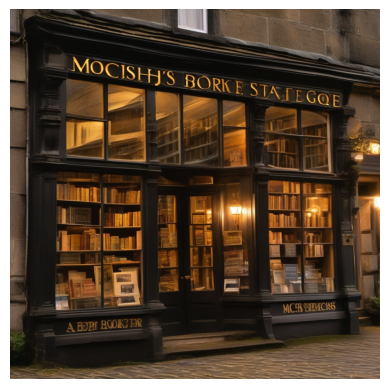

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
image_path = '/kaggle/input/test-images/Test_Images/image_0.jpg'
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


In [17]:
TEST_DIR = "/kaggle/input/test-images/Test_Images"  

test = pd.DataFrame()
test['image'], test['label'] = createdataframe2(TEST_DIR)

Loaded 200 images from /kaggle/input/test-images/Test_Images.


In [18]:


x_test = extract_features(test['image'])
print(x_test.shape)

x_test = preprocess_input(x_test)
#x_test = test_features / 255.0


  0%|          | 0/200 [00:00<?, ?it/s]

Successfully extracted features for 200 images.
(200, 224, 224, 3)


In [19]:
predictions = model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step


In [20]:
predicted_labels = ['AI' if pred < 0.5 else 'Real' for pred in predictions]

In [21]:
preview = pd.DataFrame({
    'Id': [os.path.splitext(os.path.basename(image))[0] for image in test['image']],  # Remove file extension
    'Label': predicted_labels
})

In [22]:
print(preview.head())  # Show the first few rows
print(f"Total rows in submission: {len(preview)}")

          Id Label
0   image_22    AI
1   image_53    AI
2  image_141    AI
3   image_69    AI
4   image_68  Real
Total rows in submission: 200


In [23]:
# Extract numeric part from 'Id' for correct sorting
preview['Numeric_Id'] = preview['Id'].str.extract('(\d+)').astype(int)

# Sort by the numeric part of the 'Id' column
preview = preview.sort_values(by='Numeric_Id').drop(columns=['Numeric_Id'])

# Display the updated DataFrame
print(preview)


            Id Label
103    image_0  Real
117    image_1  Real
25     image_2  Real
161    image_3  Real
13     image_4    AI
..         ...   ...
173  image_195    AI
105  image_196  Real
98   image_197  Real
27   image_198  Real
130  image_199    AI

[200 rows x 2 columns]


In [24]:
print(preview.head(65))

           Id Label
103   image_0  Real
117   image_1  Real
25    image_2  Real
161   image_3  Real
13    image_4    AI
..        ...   ...
79   image_60  Real
46   image_61  Real
24   image_62  Real
81   image_63    AI
174  image_64  Real

[65 rows x 2 columns]


In [25]:
# Save the sorted DataFrame back to CSV
preview.to_csv('/kaggle/working/wow14.csv', index=False)